# Unsupervised clustering on rock properties

Sometimes we don't have labels, but would like to discover structure in a dataset. This is what clustering algorithms attempt to do. They don't require labels from us &mdash; they are 'unsupervised'.

We'll use a subset of the [Rock Property Catalog](http://subsurfwiki.org/wiki/Rock_Property_Catalog) data, licensed CC-BY Agile Scientific. Note that the data have been preprocessed, including the addition of noise. See the notebook [RPC_for_regression_and_classification.ipynb](RPC_for_regression_and_classification.ipynb). 

We'll use two unsupervised techniques:

- k-means clustering
- DBSCAN

We do have lithology labels for this dataset, so we can use those as a measure of how well we're doing with the clustering.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
uid = "1TMqV0d6zEqhP-gK_jQlagTuPN7pFEI5rhkVN0xJIx4g"
url = f"https://docs.google.com/spreadsheets/d/{uid}/export?format=csv"

df = pd.read_csv(url)

In [3]:
df.head()

,RPC,Description,Lithology,Vp,Vs,Rho,Rho_n
0,104818,KIAMICHI FORMA. 4,sandstone,3045.6,1595.7,2108.0,2109.120585
1,104893,KIAMICHI REMOLD 3,sandstone,3000.6,1517.1,2126.0,2090.342013
2,104652,NAVAJO ARCO 2,sandstone,3363.6,2041.5,2162.0,2131.989982
3,104752,NAVAJO ARCO REMOL 1,sandstone,3195.3,1606.2,2160.0,2184.939233
4,104598,FERRON 82-3 1677.5,sandstone,4237.5,2448.6,2428.0,2472.230768


In [4]:
df.describe()

,RPC,Vp,Vs,Rho,Rho_n
count,800.000000,800.000000,800.000000,752.000000,752.000000
mean,102276.178750,3798.453532,2113.480238,2316.454788,2318.523699
std,1537.850865,1114.387572,750.387638,255.652892,256.254305
min,100031.000000,1490.711927,441.270000,1750.000000,1721.753509
25%,101112.750000,3010.248889,1520.975000,2117.000000,2115.586918
50%,102081.500000,3675.150000,2198.100000,2390.000000,2382.642687
75%,103284.750000,4664.592178,2733.805000,2530.000000,2529.145923
max,105090.000000,5993.000000,3665.000000,2780.000000,2823.287733


Notice that the count of `Rho` values is smaller than for the other properties.

Pairplots are a good way to see how the various features are distributed with respect to each other:

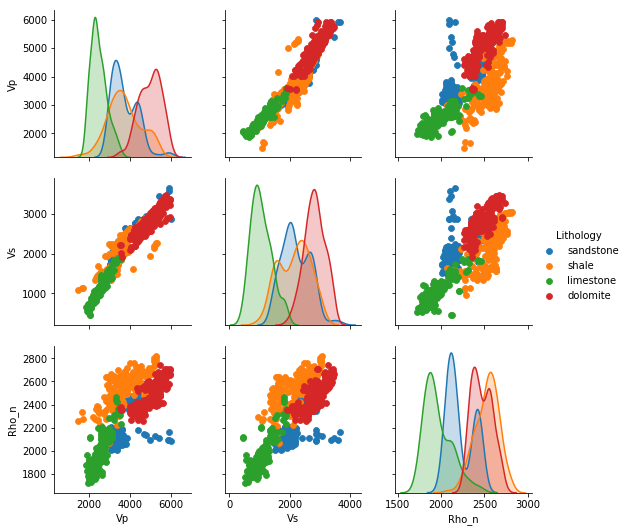

In [5]:
cols = ['Vp', 'Vs', 'Rho_n']

sns.pairplot(df.dropna(), vars=cols, hue='Lithology', plot_kws={'edgecolor': None})

## Clustering with _k_-means

From [the Wikipedia article](https://en.wikipedia.org/wiki/K-means_clustering):

> k-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.

In [6]:
from sklearn.cluster import KMeans

In [7]:
clu = KMeans()

clu.fit(df[cols].values)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

The old classic: NaNs. Remember the count of `Rho` points being smaller than the others?

The easiest thing to do, assuming we have the data, is to drop the rows with NaNs.

In [15]:
df = df.dropna()

In [16]:
clu.fit(df[cols].values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
df['K means'] = clu.predict(df[cols].values)

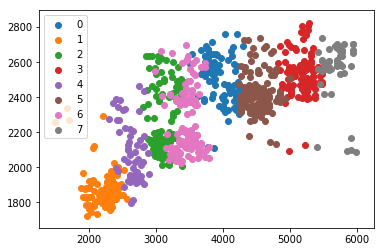

In [18]:
for name, group in df.groupby('K means'):
    plt.scatter(group.Vp, group.Rho_n, label=name)
plt.legend()

We actually do have the labels, so let's compare...

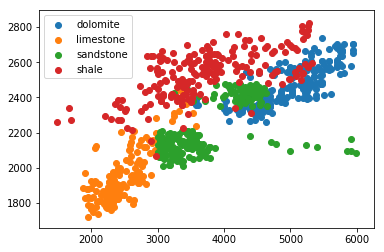

In [19]:
for name, group in df.groupby('Lithology'):
    plt.scatter(group.Vp, group.Rho_n, label=name)
plt.legend()

## Measuring the accuracy

There are metrics for comparing clusterings. For example, `adjusted_rand_score` &mdash; from the scikit-learn docs:

> The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
>
> The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:
> 
> ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
> 
> The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

In [20]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(df.Lithology, df['K means'])

0.216007927457403

That is not a good score.

## Clustering with DBSCAN

DBSCAN has nothing to do with databases. From [the Wikipedia article](https://en.wikipedia.org/wiki/DBSCAN):

> Density-based spatial clustering of applications with noise (DBSCAN) is [...] a density-based clustering algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). DBSCAN is one of the most common clustering algorithms and also most cited in scientific literature.

In [21]:
from sklearn.cluster import DBSCAN

DBSCAN()

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

There are two important hyperparameters:

- `eps`, the maximum distance between points in the same cluster.
- `min_samples`, the minimum number of samples in a cluster.

In [22]:
clu = DBSCAN(eps=150, min_samples=10)

clu.fit(df[cols].values)

DBSCAN(algorithm='auto', eps=150, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=None, p=None)

In [23]:
df['DBSCAN'] = clu.labels_

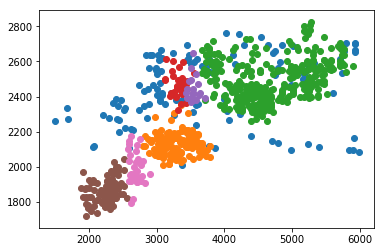

In [24]:
for name, group in df.groupby('DBSCAN'):
    plt.scatter(group.Vp, group.Rho_n, label=name)

It's a bit hard to juggle the two parameters... let's make an interactive widget:

In [25]:
from ipywidgets import interact

@interact(a=10, b=10)
def add(a, b):
    return a + b

interactive(children=(IntSlider(value=10, description='a', max=30, min=-10), IntSlider(value=10, description='…

Now we can apply this idea to our problem:

In [26]:
@interact(eps=(10, 250, 10))
def plot(eps):
    clu = DBSCAN(eps=eps)
    clu.fit(df[cols].values)
    df['DBSCAN'] = clu.labels_
    for name, group in df.groupby('DBSCAN'):
        plt.scatter(group.Vp, group.Rho_n, label=name)

interactive(children=(IntSlider(value=130, description='eps', max=250, min=10, step=10), Output()), _dom_class…

In [27]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(df.Lithology, df.DBSCAN)

0.3284809379802243

### Exercises

- Can you make the interactive widget display the Rand score? Use `plt.text(x, y, "Text")`.
- Can you write a loop to find the value of `eps` giving the highest Rand score?
- Can you add the `min_samples` parameter to the widget?
- Explore some of [the other clustering algorithms](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster).
- Try some clustering on one of your own datasets (or use something from [sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets), e.g. `sklearn.datasets.load_iris`).